In [216]:
!pip install scikeras
!pip install yfinance

In [217]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM,Dropout
from keras.layers import Dense, SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier, KerasRegressor

## Load data

In [218]:
df = yf.download("MSFT",start = "2000-01-01",end="2023-12-31")
df.drop(["Adj Close", "Volume"], axis = 1, inplace = True)

[*********************100%%**********************]  1 of 1 completed


In [219]:
df

,Open,High,Low,Close
Date,,,,
2000-01-03,58.687500,59.312500,56.000000,58.281250
2000-01-04,56.781250,58.562500,56.125000,56.312500
2000-01-05,55.562500,58.187500,54.687500,56.906250
2000-01-06,56.093750,56.937500,54.187500,55.000000
2000-01-07,54.312500,56.125000,53.656250,55.718750
...,...,...,...,...
2023-12-22,373.679993,375.179993,372.709991,374.579987
2023-12-26,375.000000,376.940002,373.500000,374.660004
2023-12-27,373.690002,375.059998,372.809998,374.070007


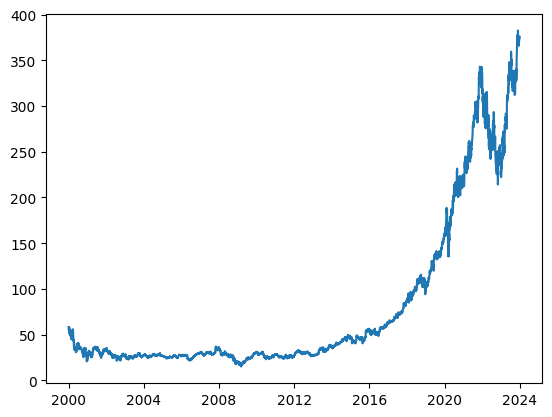

In [220]:
plt.plot(df['Close'])

## Data preprocessing


In Keras, the input shape for an LSTM (Long Short-Term Memory) layer depends on the format of your data.
The LSTM layer expects input in the form of a 3D tensor with shape (batch_size, timesteps, input_dim).

+Batch_size: The number of samples in each batch. This dimension is typically left unspecified or set to None in the input shape, allowing for variable batch sizes during training and inference.

+Timesteps: The number of time steps or sequences in your input data. For example, if you have a time series of length 100, and you want to consider 20 previous time steps as input for each sample, then timesteps would be 20.

+Input_dim: The number of features or dimensions in each time step of your input data.

In [221]:
#Sequence Creation Function for Time Series Data
def create_dataset(data: pd.DataFrame, seq_size: int):
    X = []
    y = []
    for i in range(len(data)-seq_size):
        X.append(data.iloc[i:i+seq_size, :])
        y.append(data.iloc[i+seq_size, 3])
    return np.array(X), np.array(y)


In [222]:
seq_size = 20
num_features = 4
X,Y = create_dataset(df,seq_size)
print(X.shape)
print(Y.shape)

(6017, 20, 4)
(6017,)


Since in this model, we use time series so we can not suffle data. We dive whole data into 2 part: train set and test set without suffle.

In [223]:
train_size = int(len(df)*0.8)
test_size = len(df) - train_size
x_train, x_test = X[0:train_size,:], X[train_size:,:]
y_train, y_test = Y[0:train_size], Y[train_size:]

In [224]:
scalerX = MinMaxScaler(feature_range=(0,1))
scalerY = MinMaxScaler(feature_range = (0,1))

x_train = scalerX.fit_transform(x_train.reshape(-1,num_features * seq_size))
x_test = scalerX.transform(x_test.reshape(-1,num_features * seq_size))
y_train = scalerY.fit_transform(y_train.reshape(-1,1))
y_test = scalerY.transform(y_test.reshape(-1,1))


In [225]:
x_train = x_train.reshape(-1,seq_size,num_features)
x_test = x_test.reshape(-1,seq_size, num_features)

In [226]:
print(x_train.shape)
print(y_train.shape)

(4829, 20, 4)
(4829, 1)


## Grid search

In [227]:
def create_model(neurons, optimizer):
 # create model
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(seq_size,4), activation = 'relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

In [228]:
# optimizer = ['GDA','Nadam']
# neurons = [100,500,1000,2000]
# param_grid = dict(model__neurons=neurons, model__optimizer = optimizer)

# model = KerasRegressor(model=create_model, epochs=10, batch_size=5, verbose=1)
# grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
# grid_result = grid.fit(x_train, y_train)
# best_params = grid.best_params_

In [229]:
best_model = create_model(neurons=500, optimizer='Nadam')
best_model.fit(x_train, y_train, epochs=20, batch_size=32, verbose=0)
y_pred = best_model.predict(x_test)
mse = mean_squared_error(y_test, y_pred)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


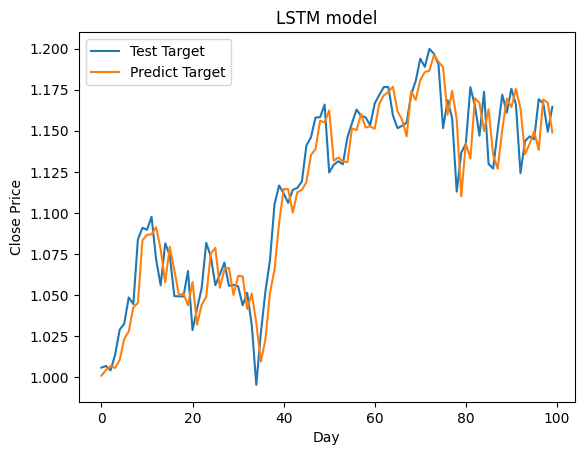

In [230]:
plt.title("LSTM model")
plt.xlabel("Day")
plt.ylabel("Close Price")
plt.plot(y_test[:100], label = "Test Target")
plt.plot(y_pred[:100], label = "Predict Target")
plt.legend()
plt.show()

## Create model


In [231]:
# create and fit the LSTM model
model = Sequential()
model.add(LSTM(units=500, input_shape=(seq_size, num_features)))
model.add(Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs= 10, batch_size=32, verbose=2)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


151/151 - 2s - 12ms/step - loss: 0.0020
Epoch 2/10
151/151 - 1s - 5ms/step - loss: 1.1894e-04
Epoch 3/10
151/151 - 1s - 8ms/step - loss: 1.1653e-04
Epoch 4/10
151/151 - 1s - 5ms/step - loss: 1.1776e-04
Epoch 5/10
151/151 - 1s - 9ms/step - loss: 1.1402e-04
Epoch 6/10
151/151 - 1s - 9ms/step - loss: 1.0036e-04
Epoch 7/10
151/151 - 1s - 7ms/step - loss: 1.0464e-04
Epoch 8/10
151/151 - 1s - 5ms/step - loss: 9.4712e-05
Epoch 9/10
151/151 - 1s - 5ms/step - loss: 1.0092e-04
Epoch 10/10
151/151 - 1s - 5ms/step - loss: 9.7157e-05


In [232]:
# make predictions
trainPredict = model.predict(x_train)
testPredict = model.predict(x_test)
print(testPredict)
# invert predictions
trainPredict = scalerY.inverse_transform(trainPredict.reshape(-1,1))
trainY = scalerY.inverse_transform(y_train.reshape(-1,1))
testPredict = scalerY.inverse_transform(testPredict.reshape(-1,1))
testY = scalerY.inverse_transform(y_test.reshape(-1,1))
# Calculate RMSE
trainScore = np.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[[1.0071816]
 [1.0108806]
 [1.0145501]
 ...
 [3.2989876]
 [3.2997632]
 [3.304275 ]]
Train Score: 1.01 RMSE
Test Score: 6.70 RMSE


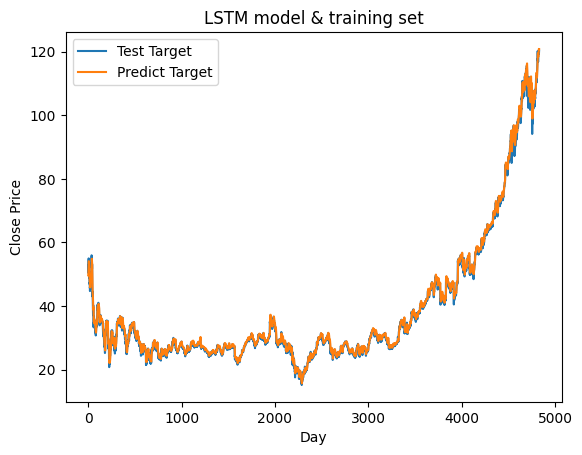

In [233]:
plt.title("LSTM model & training set")
plt.xlabel("Day")
plt.ylabel("Close Price")
plt.plot(trainY, label = "Test Target")
plt.plot(trainPredict, label = "Predict Target")
plt.legend()
plt.show()

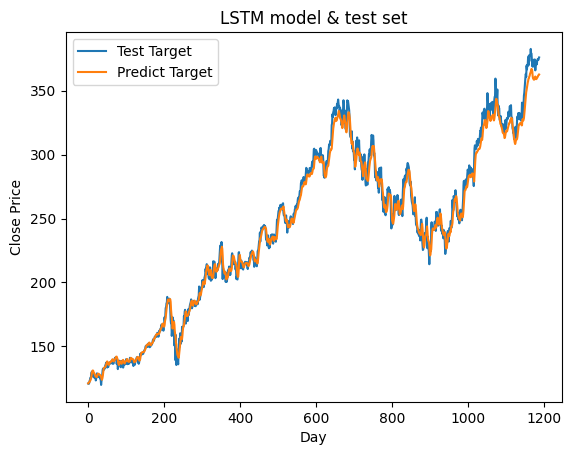

In [234]:
plt.title("LSTM model & test set")
plt.xlabel("Day")
plt.ylabel("Close Price")
plt.plot(testY, label = "Test Target")
plt.plot(testPredict, label = "Predict Target")
plt.legend()
plt.show()

In [235]:
from sklearn.metrics import r2_score
r2_test = r2_score(testY, testPredict)
r2_train = r2_score(trainY, trainPredict)
print("R-squared on train set:", r2_train)
print("R-squared on test set:", r2_test)

R-squared on train set: 0.9977457779219107
R-squared on test set: 0.9901444818973991


## Test for non-training dataset


In [236]:
df_test = yf.download("AAPL",start="2000-01-01",end="2023-12-31")
df_test.drop(["Adj Close", "Volume"], axis = 1, inplace = True)

[*********************100%%**********************]  1 of 1 completed


In [237]:
df_test.head()

,Open,High,Low,Close
Date,,,,
2000-01-03,0.936384,1.004464,0.907924,0.999442
2000-01-04,0.966518,0.987723,0.903460,0.915179
2000-01-05,0.926339,0.987165,0.919643,0.928571
2000-01-06,0.947545,0.955357,0.848214,0.848214
2000-01-07,0.861607,0.901786,0.852679,0.888393


In [238]:
otherX,otherY = create_dataset(df,seq_size)
print(otherX.shape)
print(otherY.shape)

(6017, 20, 4)
(6017,)


In [239]:
otherx_test = scalerX.transform(otherX.reshape(-1,num_features * seq_size))
othery_test = scalerY.transform(otherY.reshape(-1,1))

In [240]:
otherx_test = otherx_test.reshape(-1,seq_size, num_features)
print(otherx_test.shape)

(6017, 20, 4)


In [241]:
otherPredict = model.predict(otherx_test)

189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


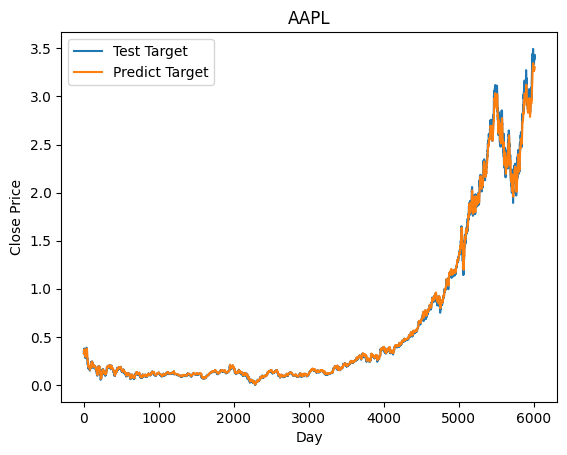

In [242]:
plt.title("AAPL")
plt.xlabel("Day")
plt.ylabel("Close Price")
plt.plot(othery_test, label = "Test Target")
plt.plot(otherPredict, label = "Predict Target")
plt.legend()
plt.show()

In [243]:
other_r2_test = r2_score(othery_test, otherPredict)
print(other_r2_test)

0.9987780493790308


As we can see, without training phase, our model can predict other stock price of IBM which fluatuate differently as well as S&P500

## RNN model

In [244]:
# create and fit the RNN network
RNNmodel = Sequential()
RNNmodel.add(SimpleRNN(500, input_shape=(seq_size, num_features), activation = 'relu'))
RNNmodel.add(Dense(1))
RNNmodel.compile(loss='mean_squared_error', optimizer='adam')
RNNmodel.fit(x_train, y_train, epochs= 10, batch_size=32, verbose=2)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


151/151 - 3s - 18ms/step - loss: 0.0017
Epoch 2/10
151/151 - 1s - 4ms/step - loss: 7.6028e-05
Epoch 3/10
151/151 - 1s - 4ms/step - loss: 7.2581e-05
Epoch 4/10
151/151 - 1s - 4ms/step - loss: 7.8212e-05
Epoch 5/10
151/151 - 1s - 4ms/step - loss: 7.1051e-05
Epoch 6/10
151/151 - 1s - 8ms/step - loss: 6.6412e-05
Epoch 7/10
151/151 - 1s - 4ms/step - loss: 8.3489e-05
Epoch 8/10
151/151 - 1s - 4ms/step - loss: 7.3652e-05
Epoch 9/10
151/151 - 1s - 4ms/step - loss: 7.0024e-05
Epoch 10/10
151/151 - 1s - 4ms/step - loss: 6.6374e-05


In [245]:
# make predictions
trainPredict = model.predict(x_train)
testPredict = model.predict(x_test)
print(testPredict)
# rescaled predictions
trainPredict = scalerY.inverse_transform(trainPredict.reshape(-1,1))
trainY = scalerY.inverse_transform(y_train.reshape(-1,1))
testPredict = scalerY.inverse_transform(testPredict.reshape(-1,1))
testY = scalerY.inverse_transform(y_test.reshape(-1,1))
# calculate RMSE
trainScore = np.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.2f RMSE' % (testScore))
r2_test = r2_score(testY, testPredict)
r2_train = r2_score(trainY, trainPredict)
print("R-squared on train set:", r2_train)
print("R-squared on test set:", r2_test)

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[[1.0071816]
 [1.0108806]
 [1.0145501]
 ...
 [3.2989876]
 [3.2997632]
 [3.304275 ]]
Train Score: 1.01 RMSE
Test Score: 6.70 RMSE
R-squared on train set: 0.9977457779219107
R-squared on test set: 0.9901444818973991


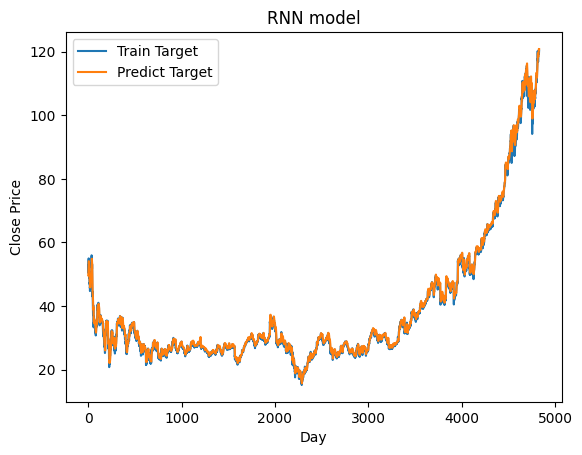

In [246]:
plt.title("RNN model")
plt.xlabel("Day")
plt.ylabel("Close Price")
plt.plot(trainY, label = "Train Target")
plt.plot(trainPredict, label = "Predict Target")
plt.legend()
plt.show()

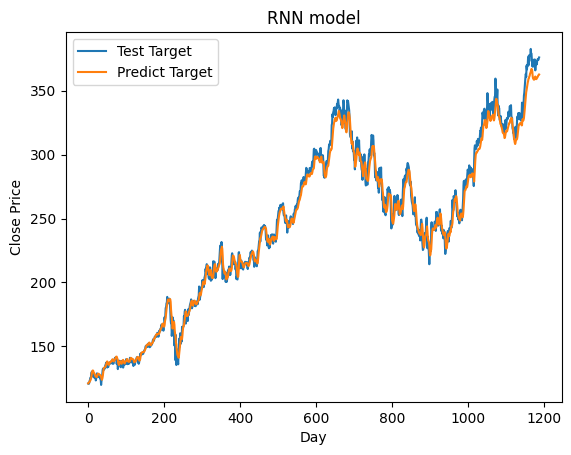

In [247]:
plt.title("RNN model")
plt.xlabel("Day")
plt.ylabel("Close Price")
plt.plot(testY, label = "Test Target")
plt.plot(testPredict, label = "Predict Target")
plt.legend()
plt.show()

## Test with random data

###### For simplictit, we create an new model with feature of each timestep is close price of previous day

In [248]:
df = yf.download("AAPL",start ="2000-01-01",end="2023-12-31")
df = df[['Close']]
scaler = MinMaxScaler()
df['Close'] = scaler.fit_transform(df['Close'].values.reshape(-1,1))

[*********************100%%**********************]  1 of 1 completed
<ipython-input-248-a79705abb19d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Close'] = scaler.fit_transform(df['Close'].values.reshape(-1,1))


In [249]:
seq_size = 30
def create_dataset(df, seq_size):
    print(df)
    df = df.values
    X = []
    y = []
    for i in range(len(df)-seq_size):
        X.append(df[i:(i+seq_size)])
        y.append(df[i+seq_size])
    return np.array(X), np.array(y)
scaledX, scaledY = create_dataset(df, seq_size)
scaledX.shape, scaledY.shape

               Close
Date                
2000-01-03  0.003867
2000-01-04  0.003441
2000-01-05  0.003509
2000-01-06  0.003103
2000-01-07  0.003306
...              ...
2023-12-22  0.977208
2023-12-26  0.974428
2023-12-27  0.974934
2023-12-28  0.977107
2023-12-29  0.971800

[6037 rows x 1 columns]


((6007, 30, 1), (6007, 1))

In [250]:
train_size = int(len(df)*0.8)
test_size = len(df) - train_size
x_train, x_test = scaledX[0:train_size,:], scaledX[train_size:,:]
y_train, y_test = scaledY[0:train_size], scaledY[train_size:]
x_train.shape, x_test.shape,y_train.shape, y_test.shape

((4829, 30, 1), (1178, 30, 1), (4829, 1), (1178, 1))

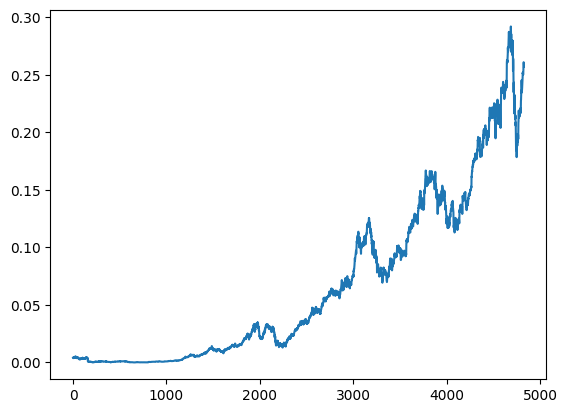

In [251]:
plt.plot(y_train)
plt.show()

In [252]:
x_train = np.reshape(x_train,(x_train.shape[0],seq_size,1))
x_test = np.reshape(x_test,(x_test.shape[0],seq_size,1))
print(len(x_test))

1178


In [253]:
model = Sequential()
model.add(LSTM(500, input_shape=(seq_size,1), activation = 'relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=10, batch_size=1, verbose=2)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4829/4829 - 33s - 7ms/step - loss: 8.6540e-05
Epoch 2/10
4829/4829 - 42s - 9ms/step - loss: 2.0481e-05
Epoch 3/10
4829/4829 - 40s - 8ms/step - loss: 1.4521e-05
Epoch 4/10
4829/4829 - 41s - 8ms/step - loss: 1.1434e-05
Epoch 5/10
4829/4829 - 41s - 8ms/step - loss: 1.0689e-05
Epoch 6/10
4829/4829 - 41s - 9ms/step - loss: 9.5499e-06
Epoch 7/10
4829/4829 - 41s - 8ms/step - loss: 6.8195e-06
Epoch 8/10
4829/4829 - 41s - 8ms/step - loss: 6.7032e-06
Epoch 9/10
4829/4829 - 42s - 9ms/step - loss: 5.7116e-06
Epoch 10/10
4829/4829 - 31s - 6ms/step - loss: 5.4293e-06


In [254]:
# make predictions
trainPredict = model.predict(x_train)
testPredict = model.predict(x_test)
print(testPredict)
# rescaled predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(y_train)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(y_test)
# calculate RMSE
trainScore = np.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.2f RMSE' % (testScore))
r2_test = r2_score(testY, testPredict)
r2_train = r2_score(trainY, trainPredict)
print("R-squared on train set:", r2_train)
print("R-squared on test set:", r2_test)

151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
[[0.2555174 ]
 [0.25567362]
 [0.25087813]
 ...
 [0.9175133 ]
 [0.91255814]
 [0.91809785]]
Train Score: 0.48 RMSE
Test Score: 8.65 RMSE
R-squared on train set: 0.9988930394456428
R-squared on test set: 0.9596984600998244


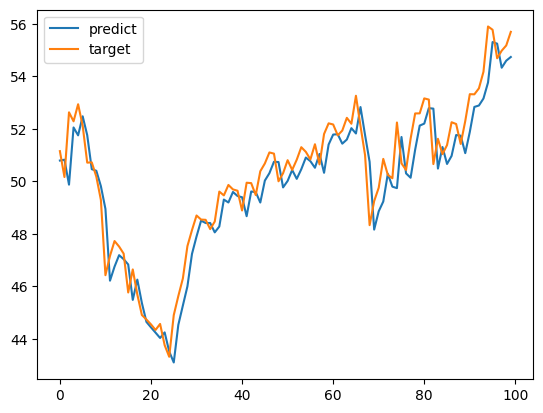

In [255]:
plt.plot(testPredict[:100], label = "predict")
plt.plot(testY[:100], label = "target")
plt.legend()

From here we can also see that compare to four-feature model, there is not many difference

#### Create random data


In [256]:
data_test = np.random.random((365,1))
data_test

array([[0.16953661],
       [0.8395941 ],
       [0.23171827],
       [0.57678437],
       [0.67362552],
       [0.98014818],
       [0.53693441],
       [0.81291339],
       [0.78937387],
       [0.21171227],
       [0.44898039],
       [0.94906861],
       [0.58141466],
       [0.00802641],
       [0.35051079],
       [0.650181  ],
       [0.53950404],
       [0.82792204],
       [0.24032902],
       [0.26975071],
       [0.44442154],
       [0.26882861],
       [0.34127422],
       [0.08299198],
       [0.22083403],
       [0.23216085],
       [0.37818197],
       [0.33971392],
       [0.1791692 ],
       [0.58033802],
       [0.53879116],
       [0.15889059],
       [0.97347629],
       [0.8790489 ],
       [0.69562962],
       [0.51601908],
       [0.96374729],
       [0.44856482],
       [0.02620004],
       [0.68328431],
       [0.11337321],
       [0.07341141],
       [0.89860671],
       [0.93114189],
       [0.42356112],
       [0.21650378],
       [0.19763548],
       [0.404

In [257]:
df_test = pd.DataFrame(data_test)

In [258]:
X_test, Y_test = create_dataset(df_test, 30)
X_test.shape

            0
0    0.169537
1    0.839594
2    0.231718
3    0.576784
4    0.673626
..        ...
360  0.312348
361  0.434790
362  0.702919
363  0.772126
364  0.316786

[365 rows x 1 columns]


(335, 30, 1)

In [259]:
y_pred = model.predict(X_test)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


In [260]:
testPredict = scaler.inverse_transform(y_pred)
testY = scaler.inverse_transform(Y_test.reshape(-1,1))

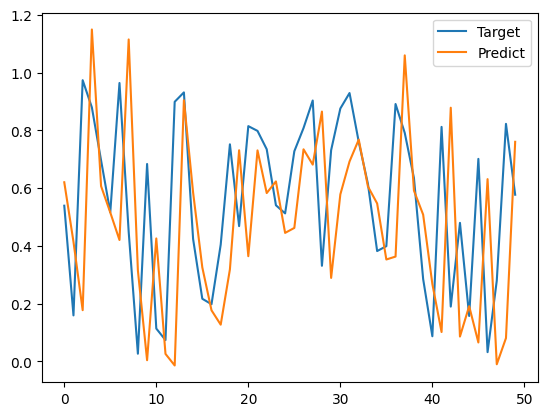

In [261]:
plt.plot(Y_test[0:50], label = 'Target')
plt.plot(y_pred[0:50], label = 'Predict')
plt.legend()

###### Shift 1 day

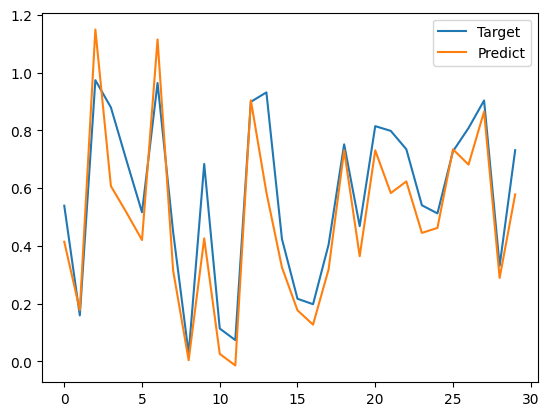

In [262]:
plt.plot(Y_test[0:30], label = 'Target')
plt.plot(y_pred[1:31], label = 'Predict')
plt.legend()